<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/ML%20EDA%20timeseries%20PCA%20DFA%20AggClust%20DWT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install MFDFA --quiet

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
# --- New Imports ---
from MFDFA import MFDFA
import pywt
# -------------------

# Load and Prepare Time Series Data

Time Series Data:
            timeseries
Date                  
2020-01-01  102.483571
2020-01-02   99.580912
2020-01-03  103.782859
2020-01-04  108.431646
2020-01-05   99.917658
2020-01-06  100.189464
2020-01-07  109.527682
2020-01-08  105.739955
2020-01-09   99.826217
2020-01-10  105.156789

Time Series Plot:


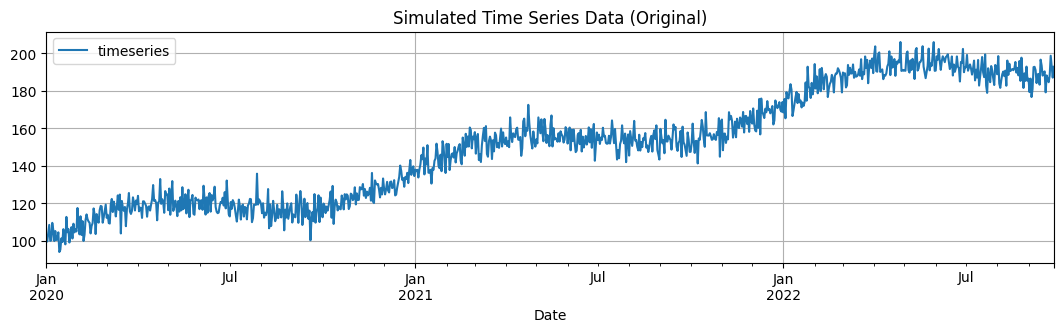

In [16]:
np.random.seed(42)
time_index = pd.date_range(start='2020-01-01', periods=1000, freq='D')
base_trend = np.linspace(100, 200, 1000)
seasonal_component = 10 * np.sin(np.arange(1000) * 2 * np.pi / 365)
noise = np.random.normal(0, 5, 1000)
timeseries = base_trend + seasonal_component + noise

df_ts = pd.DataFrame({'Date': time_index, 'timeseries': timeseries})
df_ts.set_index('Date', inplace=True)

print("Time Series Data:")
print(df_ts.head(10))
print("\nTime Series Plot:")
df_ts.plot(y='timeseries', title='Simulated Time Series Data (Original)',figsize=(13,3))
plt.grid()
plt.show()

# Feature Engineering for Clustering

In [17]:
window_size = 7
df_ts['Lag_1'] = df_ts['timeseries'].shift(1)
df_ts['Lag_2'] = df_ts['timeseries'].shift(2)
df_ts['Lag_7'] = df_ts['timeseries'].shift(7)
df_ts[f'Rolling_Mean_{window_size}'] = df_ts['timeseries'].rolling(window=window_size).mean()
df_ts[f'Rolling_Std_{window_size}'] = df_ts['timeseries'].rolling(window=window_size).std()
df_ts[f'Rolling_Max_{window_size}'] = df_ts['timeseries'].rolling(window=window_size).max()
df_ts[f'Rolling_Min_{window_size}'] = df_ts['timeseries'].rolling(window=window_size).min()
df_ts['DayOfWeek'] = df_ts.index.dayofweek
df_ts['Month'] = df_ts.index.month

df_features = df_ts.dropna()
feature_columns = [col for col in df_features.columns if col != 'timeseries']
X = df_features[feature_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
df_features


,timeseries,Lag_1,Lag_2,Lag_7,Rolling_Mean_7,Rolling_Std_7,Rolling_Max_7,Rolling_Min_7,DayOfWeek,Month
Date,,,,,,,,,,
2020-01-08,105.739955,109.527682,100.189464,102.483571,103.881454,4.161030,109.527682,99.580912,2,1
2020-01-09,99.826217,105.739955,109.527682,99.580912,103.916497,4.119602,109.527682,99.826217,3,1
2020-01-10,105.156789,99.826217,105.739955,103.782859,104.112773,4.144826,109.527682,99.826217,4,1
2020-01-11,100.396844,105.156789,99.826217,108.431646,102.964944,3.851631,109.527682,99.826217,5,1
2020-01-12,100.654719,100.396844,105.156789,99.917658,103.070238,3.763508,109.527682,99.826217,6,1
...,...,...,...,...,...,...,...,...,...,...
2022-09-22,188.307322,184.631918,186.160213,188.159373,186.638718,3.803473,190.419831,179.230419,3,9
2022-09-23,198.776992,188.307322,184.631918,189.454050,187.970567,5.969273,198.776992,179.230419,4,9
2022-09-24,193.071446,198.776992,188.307322,190.419831,188.349369,6.229084,198.776992,179.230419,5,9


# Clustering Algorithms

In [20]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)

agg_clustering = AgglomerativeClustering(n_clusters=3)
clusters_agg = agg_clustering.fit_predict(X_scaled)

# --- 4. Apply Dimensionality Reduction ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


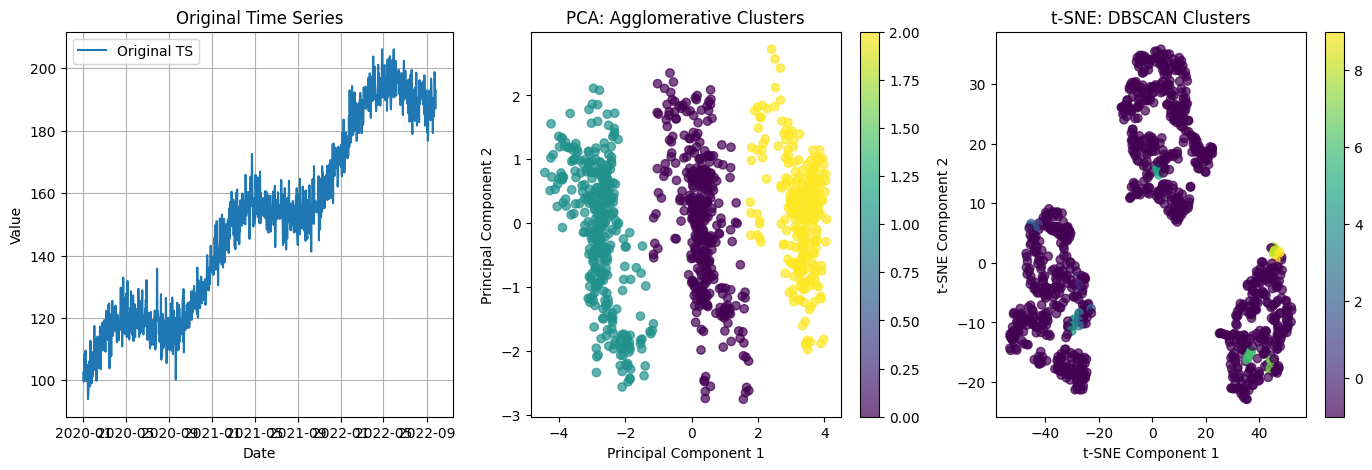

In [40]:
# --- 7. Visualize Results ---
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Original Time Series
axes[0].plot(df_ts.index, df_ts['timeseries'], label='Original TS')
axes[0].set_title('Original Time Series')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True)

# PCA Scatter Plot (Colored by Agglomerative Clusters)
scatter_pca_agg = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_agg, cmap='viridis', alpha=0.7)
axes[1].set_title('PCA: Agglomerative Clusters')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
plt.colorbar(scatter_pca_agg, ax=axes[1])



# t-SNE Scatter Plot (Colored by DBSCAN Clusters)
scatter_tsne_dbscan = axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_dbscan, cmap='viridis', alpha=0.7)
axes[2].set_title('t-SNE: DBSCAN Clusters')
axes[2].set_xlabel('t-SNE Component 1')
axes[2].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter_tsne_dbscan, ax=axes[2])


# Detrended Fluctuation Analysis (DFA)


In [26]:
ts_values = df_ts['timeseries'].values
integrated_ts = np.cumsum(ts_values - np.mean(ts_values))

N = len(integrated_ts)
min_window_size = 10
max_window_size = N // 4
window_sizes = np.unique(np.logspace(np.log10(min_window_size), np.log10(max_window_size), num=50).astype(int))
window_sizes = window_sizes[window_sizes < N]

fluctuation_values = []
for window_size in window_sizes:
    num_segments = len(integrated_ts) // window_size
    segments = integrated_ts[:num_segments * window_size].reshape(num_segments, window_size)
    reversed_ts = integrated_ts[::-1]
    num_segments_rev = len(reversed_ts) // window_size
    segments_rev = reversed_ts[:num_segments_rev * window_size].reshape(num_segments_rev, window_size)
    all_segments = np.concatenate([segments, segments_rev])

    x_axis = np.arange(window_size)
    squared_fluctuation_sum = 0.0

    for segment in all_segments:
        order = 1
        coefficients = np.polyfit(x_axis, segment, order)
        fitted_trend = np.polyval(coefficients, x_axis)
        detrended_segment = segment - fitted_trend
        squared_fluctuation_sum += np.mean(detrended_segment**2)

    mean_squared_fluctuation = squared_fluctuation_sum / len(all_segments)
    fluctuation_values.append(np.sqrt(mean_squared_fluctuation))

fluctuation_values = np.array(fluctuation_values)

log_window_sizes = np.log(window_sizes)
log_fluctuations = np.log(fluctuation_values)
fit_range_start = 5
fit_range_end = -5
slope, intercept = np.polyfit(log_window_sizes[fit_range_start:fit_range_end], log_fluctuations[fit_range_start:fit_range_end], 1)
hurst_exponent = slope
print(f"DFA: Estimated Hurst Exponent (H): {hurst_exponent:.3f}")

DFA: Estimated Hurst Exponent (H): 1.483


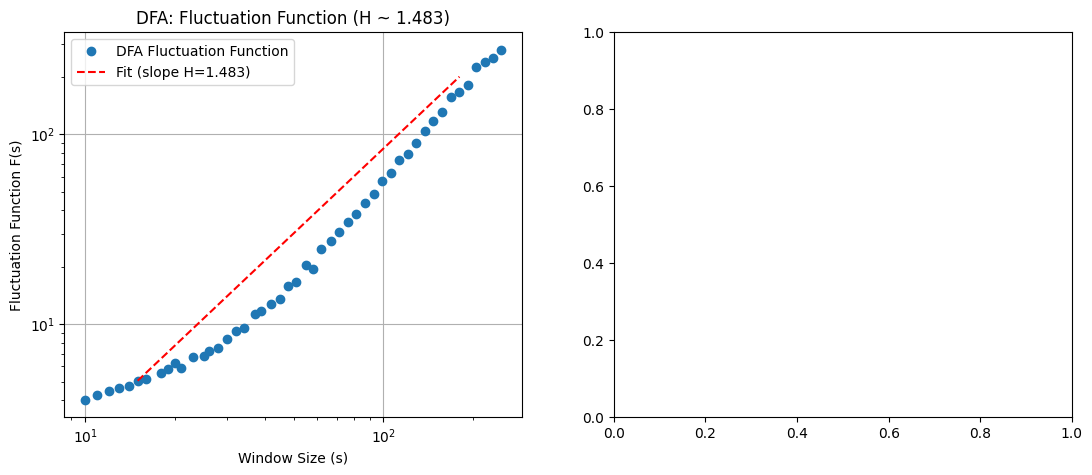

In [27]:
# --- DFA Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(13, 5))


axes[0].loglog(window_sizes, fluctuation_values, 'o', label='DFA Fluctuation Function')
fit_window_range = window_sizes[fit_range_start:fit_range_end]
fit_log_fluct_range = fluctuation_values[fit_range_start:fit_range_end]
fitted_line_y = np.exp(np.polyval([slope, np.log(fit_log_fluct_range[0]) - slope * np.log(fit_window_range[0])], np.log(fit_window_range)))
axes[0].loglog(fit_window_range, fitted_line_y, 'r--', label=f'Fit (slope H={slope:.3f})')
axes[0].set_title(f'DFA: Fluctuation Function (H ~ {hurst_exponent:.3f})')
axes[0].set_xlabel('Window Size (s)')
axes[0].set_ylabel('Fluctuation Function F(s)')
axes[0].legend()
axes[0].grid(True)

# Discrete Wavelet Transform (DWT)

In [29]:
wavelet_name = 'db4'
try:
    cA1, cD1 = pywt.dwt(df_ts['timeseries'].values, wavelet_name)
    print(f"DWT: Using wavelet '{wavelet_name}'")
    print(f"DWT: Approximation coefficients (cA1) shape: {cA1.shape}")
    print(f"DWT: Detail coefficients (cD1) shape: {cD1.shape}")
except Exception as e:
    print(f"DWT failed: {e}")
    cA1, cD1 = None, None

# Perform a multi-level DWT for visualization
level = 3 # Reduced level for clearer subplot visualization
try:
    coeffs = pywt.wavedec(df_ts['timeseries'].values, wavelet_name, level=level)
    print(f"DWT: Multi-level decomposition (level {level}) - Number of coefficient sets: {len(coeffs)}")
except Exception as e:
    print(f"DWT Multi-level failed: {e}")
    coeffs = []

DWT: Using wavelet 'db4'
DWT: Approximation coefficients (cA1) shape: (503,)
DWT: Detail coefficients (cD1) shape: (503,)
DWT: Multi-level decomposition (level 3) - Number of coefficient sets: 4


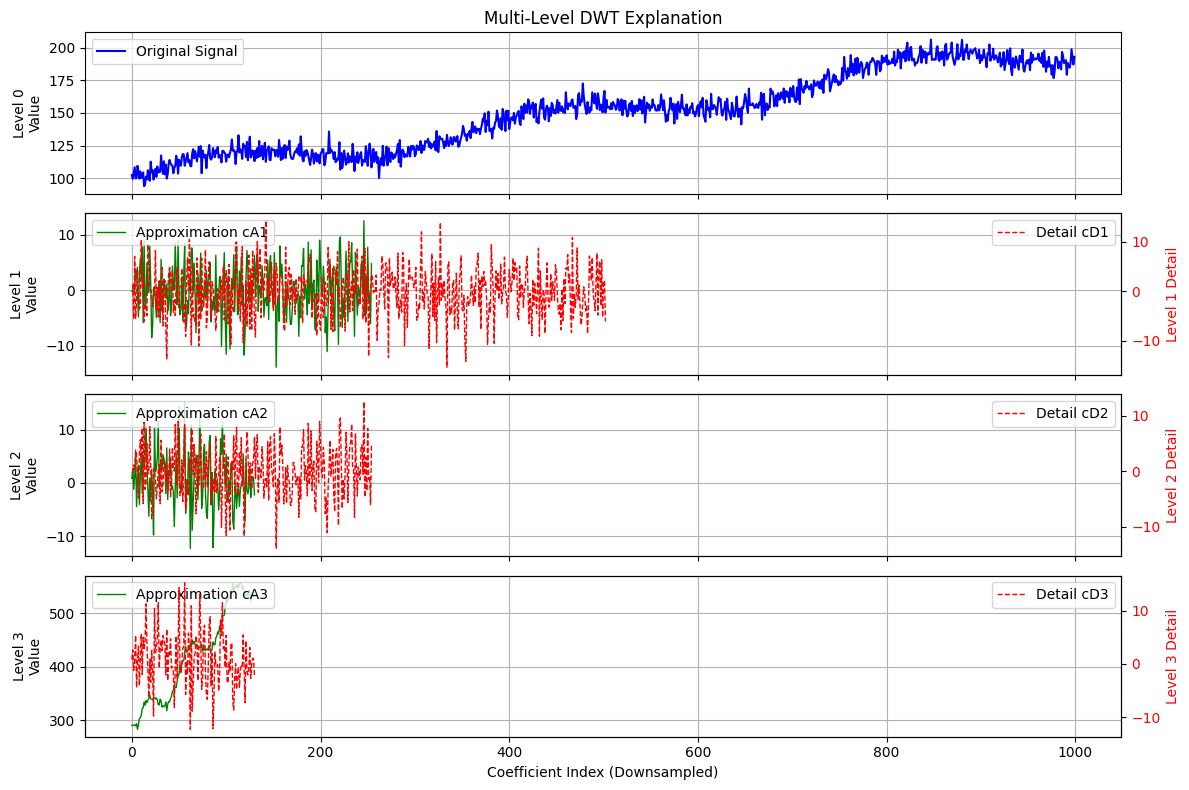

In [34]:
# --- NEW: DWT Visualization (Multi-Level) - Explained with Subplots ---
if coeffs:
    # Create a figure specifically for multi-level DWT explanation
    fig_dwt_explained, ax_dwt_explained = plt.subplots(level + 1, 1, figsize=(12, 2*(level+1)), sharex=True)
    if level == 1: # Handle case where subplots returns a single axis object
        ax_dwt_explained = [ax_dwt_explained]

    # Plot the original signal
    ax_dwt_explained[0].plot(np.arange(len(df_ts['timeseries'])), df_ts['timeseries'], label='Original Signal', color='blue')
    ax_dwt_explained[0].set_ylabel('Level 0\nValue')
    ax_dwt_explained[0].set_title('Multi-Level DWT Explanation')
    ax_dwt_explained[0].legend(loc='upper left')
    ax_dwt_explained[0].grid(True)

    # Iterate through decomposition levels
    for i in range(1, level + 1):
        # Get coefficients for level i
        # coeffs[0] is cA_level, coeffs[1] is cD_level, ..., coeffs[level] is cD_1
        # So cA for level i is coeffs[level - i], and cD for level i is coeffs[level - i + 1]
        approx_level = level - i
        detail_level = level - i + 1

        cA_i = coeffs[approx_level]
        cD_i = coeffs[detail_level]

        # Create index for coefficients at this level
        coeff_index = np.arange(len(cA_i))

        # Plot Approximation (Low-frequency content) for level i
        ax_dwt_explained[i].plot(coeff_index, cA_i, label=f'Approximation cA{i}', color='green', linewidth=1)
        ax_dwt_explained[i].set_ylabel(f'Level {i}\nValue')
        ax_dwt_explained[i].legend(loc='upper left')
        ax_dwt_explained[i].grid(True)

        # Add a second y-axis for Detail (High-frequency content) for level i
        ax_detail = ax_dwt_explained[i].twinx()
        coeff_index_detail = np.arange(len(cD_i))
        ax_detail.plot(coeff_index_detail, cD_i, label=f'Detail cD{i}', color='red', linewidth=1, linestyle='--')
        ax_detail.set_ylabel(f'Level {i} Detail', color='red')
        ax_detail.tick_params(axis='y', labelcolor='red')
        ax_detail.legend(loc='upper right')

    ax_dwt_explained[-1].set_xlabel('Coefficient Index (Downsampled)')
    fig_dwt_explained.tight_layout()
    plt.show()

    # Also plot the combined view in the main figure grid
    # Plot coefficients against their own index for simplicity
    coeff_index_approx = np.arange(len(coeffs[0]))
    axes[0].plot(coeff_index_approx, coeffs[0], label=f'Approximation (cA{level})', linewidth=1, color='green')

    for i, detail in enumerate(coeffs[1:]): # coeffs[1] is cD_level, ..., coeffs[level] is cD_1
        level_num = level - i
        coeff_index_detail = np.arange(len(detail))
        axes[0].plot(coeff_index_detail, detail, label=f'Detail (cD{level_num})', linewidth=1, linestyle='--')

    axes[0].set_title(f'DWT: Multi-Level ({wavelet_name}, level={level}) - Coefficients Overview')
    axes[0].set_xlabel('Coefficient Index')
    axes[0].set_ylabel('Value')
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axes[0].grid(True)
else:
    axes[0].text(0.5, 0.5, 'DWT Multi-Level Failed', horizontalalignment='center', verticalalignment='center', transform=axes[1, 2].transAxes)
    axes[0].set_title('DWT: Multi-Level Decomposition')

# Visualization

/tmp/ipython-input-3299249376.py:9: UserWarning: Adding colorbar to a different Figure <Figure size 1700x500 with 5 Axes> than <Figure size 1700x500 with 4 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter_tsne_dbscan, ax=axes[0]) # Reuse colormap
/tmp/ipython-input-3299249376.py:16: UserWarning: Adding colorbar to a different Figure <Figure size 1700x500 with 5 Axes> than <Figure size 1700x500 with 5 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter_tsne_dbscan, ax=axes[1]) # Reuse colormap


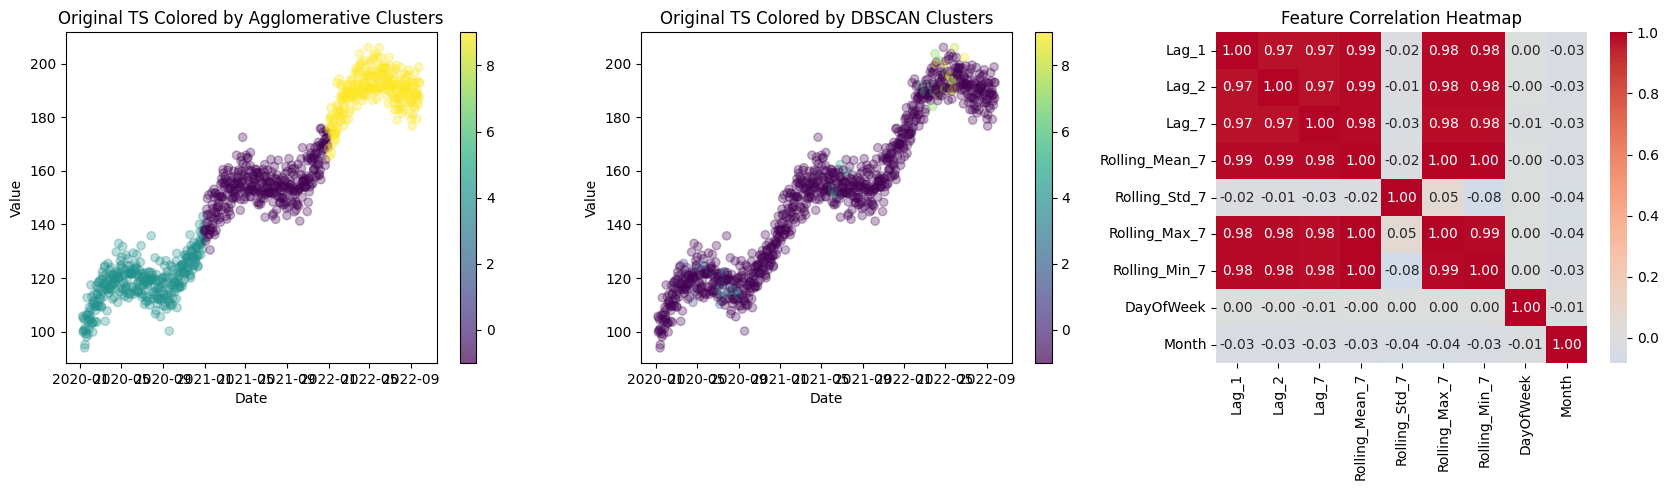


Silhouette Score for DBSCAN: -0.465
Silhouette Score for Agglomerative Clustering: 0.361


In [44]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))

# --- Clustering Results on Original TS ---
original_ts_index = df_features.index
axes[0].scatter(original_ts_index, df_features['timeseries'], c=clusters_agg, cmap='viridis', alpha=0.3)
axes[0].set_title('Original TS Colored by Agglomerative Clusters')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
plt.colorbar(scatter_tsne_dbscan, ax=axes[0]) # Reuse colormap

# --- Clustering Results on Original TS (DBSCAN) ---
axes[1].scatter(original_ts_index, df_features['timeseries'], c=clusters_dbscan, cmap='viridis', alpha=0.3)
axes[1].set_title('Original TS Colored by DBSCAN Clusters')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
plt.colorbar(scatter_tsne_dbscan, ax=axes[1]) # Reuse colormap

# --- Feature Correlation Heatmap ---
feature_corr = df_features[feature_columns].corr()
sns.heatmap(feature_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, ax=axes[2])
axes[2].set_title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

# --- 8. Evaluate Clustering ---
try:
    sil_score_dbscan = silhouette_score(X_scaled, clusters_dbscan) if len(set(clusters_dbscan)) > 1 else -1
    print(f"\nSilhouette Score for DBSCAN: {sil_score_dbscan:.3f}")
except ValueError as e:
    print(f"\nSilhouette Score for DBSCAN failed (likely due to noise points or single cluster): {e}")

try:
    sil_score_agg = silhouette_score(X_scaled, clusters_agg) if len(set(clusters_agg)) > 1 else -1
    print(f"Silhouette Score for Agglomerative Clustering: {sil_score_agg:.3f}")
except ValueError as e:
    print(f"Silhouette Score for Agglomerative Clustering failed: {e}")